## 1. load数据集

In [13]:
import csv
import io
import json
import os
import pickle
import subprocess
import sys

import cv2
import matplotlib.pyplot as plt
import mmengine
import numpy as np
import torch
import tqdm
import yaml
from dsdl.dataset import DSDLConcatDataset, DSDLDataset
from mmeval import MeanIoU
from PIL import Image
from segment_anything import SamPredictor, sam_model_registry
from torchvision import transforms

In [2]:
def load_dataset(**args):
    fields_list = ["Image", "LabelMap", "InstanceMap", "Polygon"]

    split = args["split"]
    yaml_path = os.path.join(args["dsdl_dir"], f"set-{split}/{split}.yaml")

    loc_config = dict(
        type="PetrelFileReader",
        working_dir=args["working_dir"],
        conf_path=args["petrel_cfg"],
    )

    ds = DSDLDataset(
        dsdl_yaml=yaml_path, location_config=loc_config, required_fields=fields_list
    )
    #     ds.data_list = ds.data_list[0:args["sample_nums"]]
    ds.data_list = ds.data_list[0:10]
    return ds

In [4]:
%%time

with open("data_cfgs.json", "r") as f:
    cfgs = json.load(f)["cfgs"]

all_dataset = []
for item in cfgs:
    all_dataset.append(load_dataset(**item))

Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/BBBC038v1/set-stage1_train/stage1_train.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/DOORS/set-DS1_T/DS1_T.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/TimberSeg/set-original/original.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/NDD20/set-ABOVE/ABOVE.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/LVIS/set-val/val.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/STREETS/set-train/train.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/ZeroWaste-f/set-train/train.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (s

In [5]:
for ds in all_dataset:

    T = {
        "Image": lambda x: x[0].to_array(),
        "LabelMap": lambda x: x[0].to_array(),
        "InstanceMap": lambda x: x[0].to_array(),
        "Polygon": lambda x: x,
    }

    ds.set_transform(T)

## 2. 检查每个数据集的图片和mask

dataset num: 14
dataset name: BBBC038v1
dict_keys(['Image', 'LabelMap', 'InstanceMap']) (256, 256, 4)


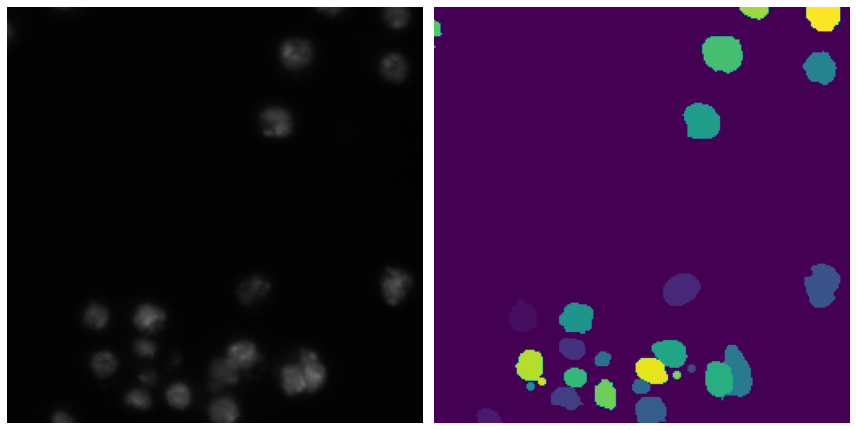

dataset name: DOORS
dict_keys(['Image', 'LabelMap']) (128, 128)


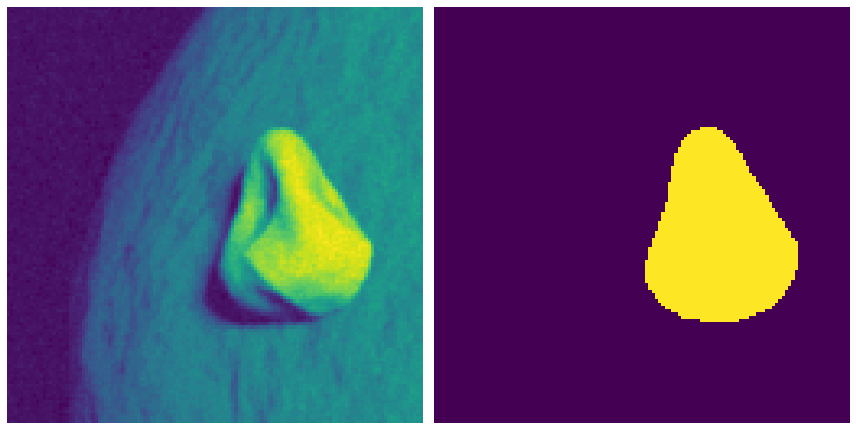

dataset name: TimberSeg
dict_keys(['Image', 'Polygon']) (3024, 4032, 3)


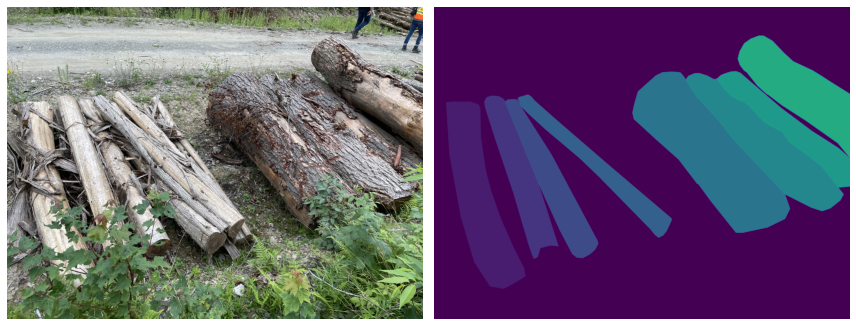

dataset name: NDD20
dict_keys(['Image', 'Polygon']) (3456, 5184, 3)


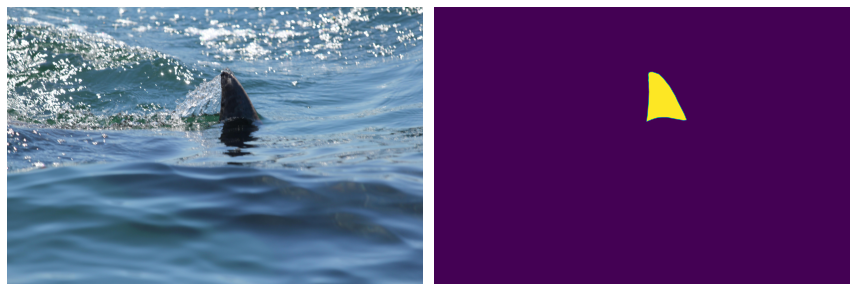

dataset name: LVIS
dict_keys(['Image', 'Polygon']) (480, 640, 3)


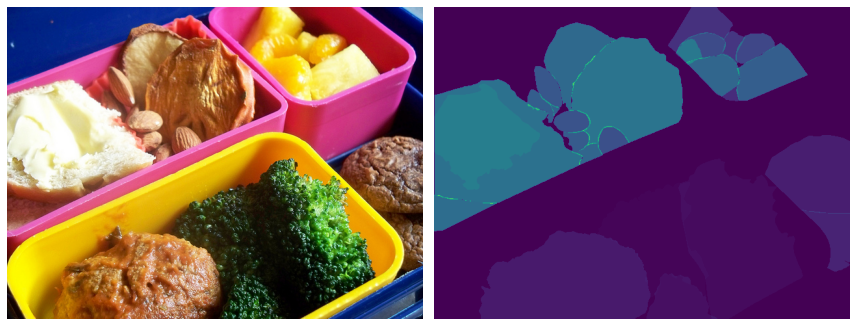

dataset name: STREETS
dict_keys(['Image', 'Polygon']) (480, 720, 3)


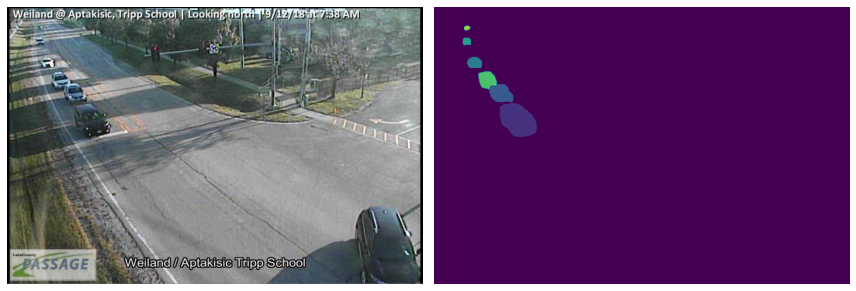

dataset name: ZeroWaste-f
dict_keys(['Image', 'LabelMap']) (1080, 1920, 3)


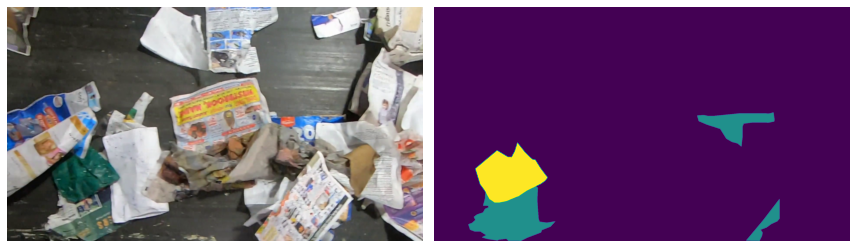

dataset name: iShape
dict_keys(['Image', 'InstanceMap']) (1024, 1024, 3)


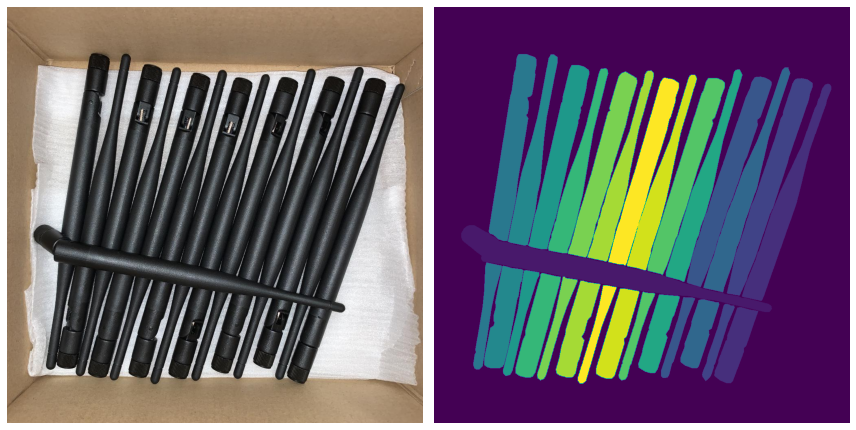

dataset name: OVIS
dict_keys(['Image', 'LabelMap', 'InstanceMap']) (886, 1920, 3)


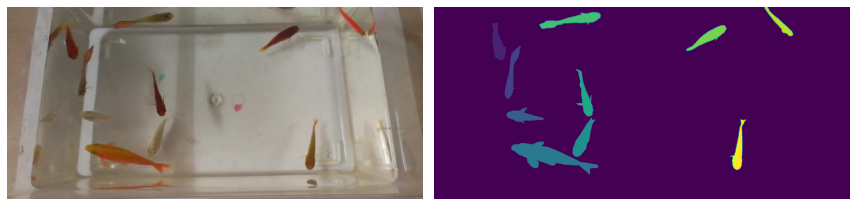

dataset name: NDISPark
dict_keys(['Image', 'Polygon']) (1658, 2400, 3)


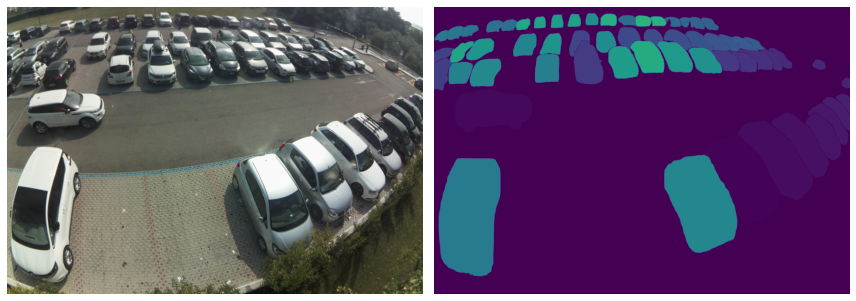

dataset name: Plittersdorf
dict_keys(['Image', 'Polygon']) (800, 1920)


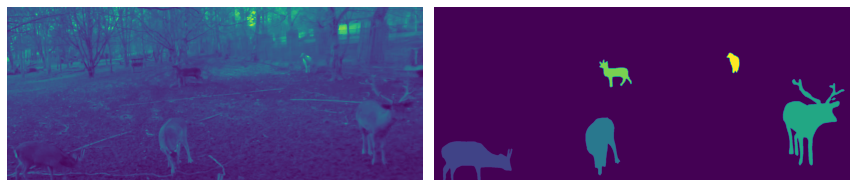

dataset name: TrashCan
dict_keys(['Image', 'Polygon']) (270, 480, 3)


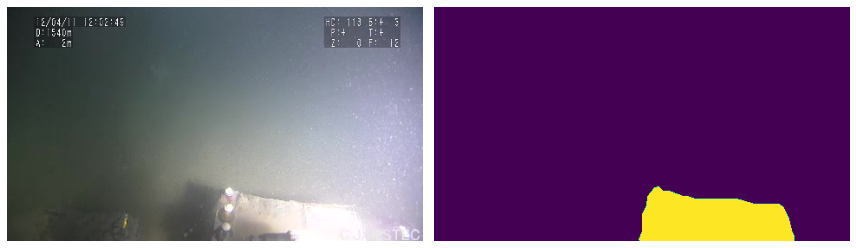

dataset name: DRAM
dict_keys(['Image', 'LabelMap']) (1000, 781, 3)


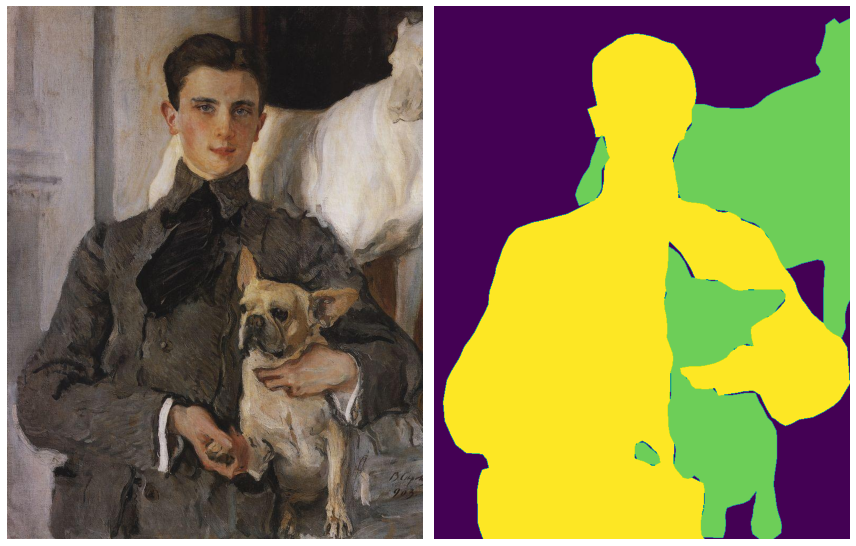

dataset name: GTEA
dict_keys(['Image', 'LabelMap']) (405, 720, 3)


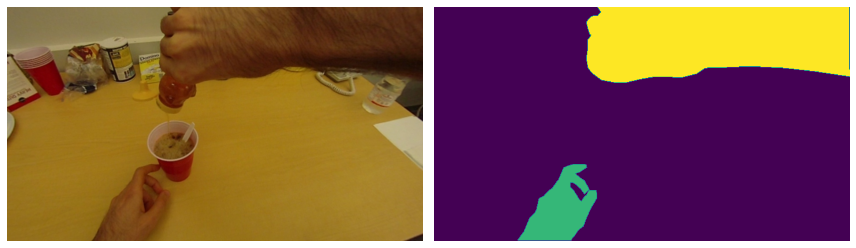

In [6]:
print("dataset num:", len(all_dataset))

for ds in all_dataset:
    print("dataset name:", ds._dsdl_yaml.split("/")[1])
    for data in ds:
        print(data.keys(), data.Image.shape)

        fig, ax = plt.subplots(1, 2, figsize=(12, 12))
        if "Polygon" in data.keys():
            img = data.Image
            mask = 0
            for pix, P in enumerate(data.Polygon):
                mask = mask + (pix + 1) * P.to_mask(imsize=data.Image.shape[0:2])

        elif "InstanceMap" in data.keys():
            img = data.Image
            mask = data.InstanceMap

        elif "LabelMap" in data.keys():
            img = data.Image
            mask = data.LabelMap
        else:
            continue

        ax[0].imshow(img)
        ax[0].axis("off")

        ax[1].imshow(mask)
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()
        break

## 3. 获取masks和mask中心点

In [7]:
def get_gt_masks(data):
    """
    input: single data in dataset, such as {"Image": xxx, "Polygon": xxx}
    output: masks array, shaped as (N, H, W), N means instance nums.
    """
    if "InstanceMap" in data.keys():
        img = data.Image
        single_mask = data.InstanceMap

        pix_values = np.unique(single_mask)
        masks = np.zeros(
            (len(pix_values) - 1, single_mask.shape[0], single_mask.shape[1])
        )
        for index, pix in enumerate(pix_values[1:]):
            masks[index - 1][single_mask == pix] = 1

    elif "Polygon" in data.keys():
        img = data.Image
        masks = np.zeros((len(data.Polygon), data.Image.shape[0], data.Image.shape[1]))
        idx = 0
        for P in data.Polygon:
            m = P.to_mask(imsize=data.Image.shape[0:2])
            if m.sum() > 0:
                masks[idx] = m
                idx += 1
        masks = masks[0:idx, :, :]

    elif "LabelMap" in data.keys():
        img = data.Image
        single_mask = data.LabelMap

        pix_values = np.unique(single_mask)
        masks = np.zeros(
            (len(pix_values) - 1, single_mask.shape[0], single_mask.shape[1])
        )
        for index, pix in enumerate(pix_values[1:]):
            masks[index - 1][single_mask == pix] = 1

    else:
        print("sample have no mask info !")
        raise

    return masks.astype(np.int32)


def get_mask_center(mask, use_area=False):
    """
    input: np.array shaped as (H, W);
    return: list of int, such as [x, y]
    """
    if use_area:
        coords = np.where(mask == 1)
        x, y = coords[1].mean(), coords[0].mean()
        return [int(x), int(y)]
    else:
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        M = cv2.moments(contours[-1])
        if M["m00"] == 0:
            M["m00"] += 10 ** -8
        return [int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])]

In [8]:
for ds in all_dataset:
    print("dataset name:", ds._dsdl_yaml.split("/")[1])
    for data in ds:
        print(data.keys(), data.Image.shape)
        masks = get_gt_masks(data)
        print("masks shape:", masks.shape)
        break

dataset name: BBBC038v1
dict_keys(['Image', 'LabelMap', 'InstanceMap']) (256, 256, 4)
masks shape: (27, 256, 256)
dataset name: DOORS
dict_keys(['Image', 'LabelMap']) (128, 128)
masks shape: (1, 128, 128)
dataset name: TimberSeg
dict_keys(['Image', 'Polygon']) (3024, 4032, 3)
masks shape: (8, 3024, 4032)
dataset name: NDD20
dict_keys(['Image', 'Polygon']) (3456, 5184, 3)
masks shape: (1, 3456, 5184)
dataset name: LVIS
dict_keys(['Image', 'Polygon']) (480, 640, 3)
masks shape: (27, 480, 640)
dataset name: STREETS
dict_keys(['Image', 'Polygon']) (480, 720, 3)
masks shape: (6, 480, 720)
dataset name: ZeroWaste-f
dict_keys(['Image', 'LabelMap']) (1080, 1920, 3)
masks shape: (2, 1080, 1920)
dataset name: iShape
dict_keys(['Image', 'InstanceMap']) (1024, 1024, 3)
masks shape: (15, 1024, 1024)
dataset name: OVIS
dict_keys(['Image', 'LabelMap', 'InstanceMap']) (886, 1920, 3)
masks shape: (10, 886, 1920)
dataset name: NDISPark
dict_keys(['Image', 'Polygon']) (1658, 2400, 3)
masks shape: (59, 16

[1723, 522]


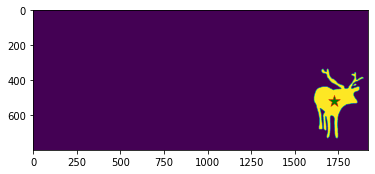

In [9]:
data_idx, sample_idx, instance_idx = 10, 0, 2

masks = get_gt_masks(all_dataset[data_idx][sample_idx])
center_point = get_mask_center(masks[instance_idx])
print(center_point)

plt.imshow(masks[instance_idx])
plt.scatter(
    [center_point[0]],
    [center_point[1]],
    color="green",
    marker="*",
    s=150,
    edgecolor="red",
    linewidth=0.5,
)

## 4. 根据point预测mask

In [10]:
def mask_iou(det_mask, pred_mask):
    """
    Computes IoU between two masks
    Input: two 2D array mask
    """
    Union = (pred_mask + det_mask) != 0
    Intersection = (pred_mask * det_mask) != 0
    return np.sum(Intersection) / np.sum(Union)


def pred_with_point_sampling(predictor, image, masks, points, pred_type="default"):
    assert pred_type in ["default", "oracle"]

    if len(image.shape) == 2:  # 单通道
        img = image[..., np.newaxis]
        img = np.repeat(img, 3, axis=-1)
        predictor.set_image(img)
    elif len(image.shape) == 3:
        if image.shape[-1] == 3:  # 正常三图片
            predictor.set_image(image)
        else:  # 多通道图片，取前三个通道
            predictor.set_image(image[:, :, 0:3])

    else:
        print(f"unsupport image with shape as {image.shape} !")
        return [], []

    pred_masks = []
    ious = []

    for idx in range(len(masks)):
        center_point = get_mask_center(masks[idx], use_area=True)
        input_point = np.array([points[idx]])
        input_label = np.array([1])

        preds, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            box=None,
            multimask_output=pred_type == "oracle",
        )

        if pred_type == "oracle":
            max_mask_id = 0
            max_iou = 0
            for midx in range(3):
                iou = mask_iou(masks[idx], preds[midx])
                if iou > max_iou:
                    max_iou = iou
                    max_mask_id = midx
            pred_masks.append(preds[max_mask_id])
            ious.append(max_iou)
        else:
            pred_masks.append(preds[0])
            ious.append(mask_iou(masks[idx], preds[0]))
    return pred_masks, ious

In [14]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda:7"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [15]:
image = all_dataset[data_idx][sample_idx].Image
masks = get_gt_masks(all_dataset[data_idx][sample_idx])
points = [get_mask_center(masks[i]) for i in range(masks.shape[0])]

mask iou(default): 0.8367451846028242 mask iou(oracle): 0.8430876580898387


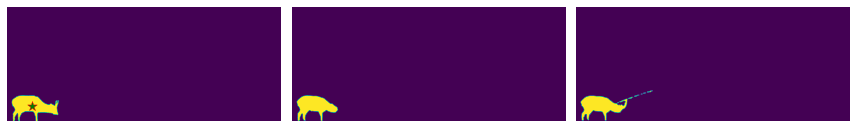

mask iou(default): 0.9600734477752156 mask iou(oracle): 0.9573019271948608


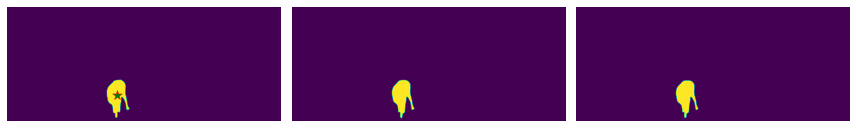

mask iou(default): 0.6398545889607252 mask iou(oracle): 0.6900059434005394


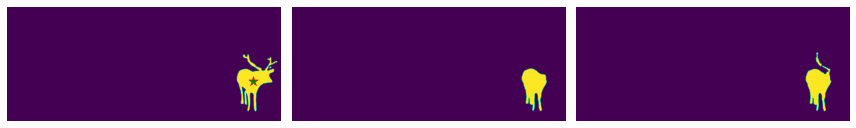

mask iou(default): 0.6734195752989993 mask iou(oracle): 0.670019870839543


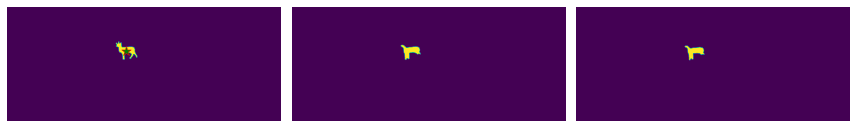

mask iou(default): 0.8659916617033949 mask iou(oracle): 0.8581100971445393


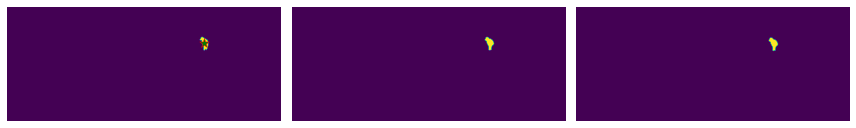

In [16]:
pred_masks, ious = pred_with_point_sampling(
    predictor, image, masks, points, pred_type="default"
)

pred_masks_oracle, ious_oracle = pred_with_point_sampling(
    predictor, image, masks, points, pred_type="oracle"
)

for mask, point, pred_mask, iou, oracle_mask, oracle_iou in zip(
    masks, points, pred_masks, ious, pred_masks_oracle, ious_oracle
):
    print("mask iou(default):", iou, "mask iou(oracle):", oracle_iou)
    fig, ax = plt.subplots(1, 3, figsize=(12, 8))

    ax[0].imshow(mask)
    ax[0].scatter(
        [point[0]],
        [point[1]],
        color="green",
        marker="*",
        s=100,
        edgecolor="red",
        linewidth=0.5,
    )
    ax[0].axis("off")

    ax[1].imshow(pred_mask)
    ax[1].axis("off")

    ax[2].imshow(oracle_mask)
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

## 5. 批量测试，输出miou

In [54]:
def batch_pred_with_point_sampling(
    predictor, image, masks, points, pred_type="default"
):
    assert pred_type in ["default", "oracle"]

    if len(image.shape) == 2:  # 单通道
        img = image[..., np.newaxis]
        img = np.repeat(img, 3, axis=-1)
        predictor.set_image(img)
    elif len(image.shape) == 3:
        if image.shape[-1] == 3:  # 正常三图片
            predictor.set_image(image)
        else:  # 多通道图片，取前三个通道
            predictor.set_image(image[:, :, 0:3])

    else:
        print(f"unsupport image with shape as {image.shape} !")
        return [], []

    point_coords = torch.tensor(
        [np.array([P]) for P in points], device=predictor.device
    )

    point_labels = torch.tensor(
        [np.array([1]) for P in points], device=predictor.device
    )

    transformed_points = predictor.transform.apply_coords_torch(
        point_coords, image.shape[:2]
    )
    preds, _, _ = predictor.predict_torch(
        point_coords=transformed_points,
        point_labels=point_labels,
        boxes=None,
        multimask_output=False,
    )

    pred_masks = []
    ious = []
    for idx in range(len(masks)):
        pred = preds[idx].cpu().numpy()
        if pred_type == "oracle":
            max_mask_id = 0
            max_iou = 0
            for midx in range(3):
                iou = mask_iou(masks[idx], pred[midx])
                if iou > max_iou:
                    max_iou = iou
                    max_mask_id = midx
            pred_masks.append(pred[max_mask_id])
            ious.append(max_iou)
        else:
            pred_masks.append(pred[0])
            ious.append(mask_iou(masks[idx], pred[0]))
    return pred_masks, ious

In [72]:
%%time

print("dataset num:", len(all_dataset))

eval_results = []

for ds in all_dataset:
    iou_sum = 0
    mask_nums = 0

    for data in tqdm.tqdm(ds):
        if (
            "LabelMap" not in data.keys()
            and "InstanceMap" not in data.keys()
            and "Polygon" not in data.keys()
        ):
            continue
        masks = get_gt_masks(data)
        points = [get_mask_center(masks[i]) for i in range(masks.shape[0])]
        if len(masks) > 0:
            pred_masks, ious = batch_pred_with_point_sampling(
                predictor, data.Image, masks, points, pred_type="default"
            )
            iou_sum += sum(ious)
            mask_nums += len(ious)

    print("==> dataset name:", ds._dsdl_yaml.split("/")[1])
    print("        mask nums:", mask_nums)
    print("        mIoU:", round(iou_sum / mask_nums, 3))

    eval_results.append(
        {
            "dataset name": ds._dsdl_yaml.split("/")[1],
            "mask nums": mask_nums,
            "mIoU": round(iou_sum / mask_nums, 3),
        }
    )

dataset num: 14


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


==> dataset name: BBBC038v1
        mask nums: 365
        mIoU: 0.676


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


==> dataset name: DOORS
        mask nums: 10
        mIoU: 0.847


100%|██████████| 10/10 [01:29<00:00,  8.95s/it]


==> dataset name: TimberSeg
        mask nums: 102
        mIoU: 0.733


100%|██████████| 10/10 [01:43<00:00, 10.38s/it]


==> dataset name: NDD20
        mask nums: 13
        mIoU: 0.802


100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


==> dataset name: LVIS
        mask nums: 90
        mIoU: 0.7


100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


==> dataset name: STREETS
        mask nums: 77
        mIoU: 0.486


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


==> dataset name: ZeroWaste-f
        mask nums: 18
        mIoU: 0.288


100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


==> dataset name: iShape
        mask nums: 93
        mIoU: 0.517


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


==> dataset name: OVIS
        mask nums: 100
        mIoU: 0.851


100%|██████████| 10/10 [00:41<00:00,  4.11s/it]


==> dataset name: NDISPark
        mask nums: 302
        mIoU: 0.493


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


==> dataset name: Plittersdorf
        mask nums: 41
        mIoU: 0.77


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


==> dataset name: TrashCan
        mask nums: 19
        mIoU: 0.525


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


==> dataset name: DRAM
        mask nums: 19
        mIoU: 0.36


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

==> dataset name: GTEA
        mask nums: 18
        mIoU: 0.71
CPU times: user 4min 3s, sys: 1min 27s, total: 5min 30s
Wall time: 5min 3s


In [18]:
# import pickle

# with open(r"eval_results.pkl", "wb") as f:
#     pickle.dump(eval_results, f)

# with open(r"eval_results.pkl", "rb") as f:
#     eval_results = pickle.load(f)

In [20]:
eval_results

[{'dataset name': 'NDD20',
  'mask nums': 2939,
  'imshape': '(3456, 5184, 3)',
  'mIoU': 0.852},
 {'dataset name': 'DOORS',
  'mask nums': 9971,
  'imshape': '(128, 128)',
  'mIoU': 0.779},
 {'dataset name': 'GTEA',
  'mask nums': 1187,
  'imshape': '(405, 720, 3)',
  'mIoU': 0.73},
 {'dataset name': 'Plittersdorf',
  'mask nums': 151,
  'imshape': '(800, 1920)',
  'mIoU': 0.727},
 {'dataset name': 'BBBC038v1',
  'mask nums': 10231,
  'imshape': '(256, 256, 4)',
  'mIoU': 0.711},
 {'dataset name': 'TimberSeg',
  'mask nums': 2485,
  'imshape': '(3024, 4032, 3)',
  'mIoU': 0.698},
 {'dataset name': 'OVIS',
  'mask nums': 17181,
  'imshape': '(886, 1920, 3)',
  'mIoU': 0.655},
 {'dataset name': 'STREETS',
  'mask nums': 9960,
  'imshape': '(480, 720, 3)',
  'mIoU': 0.624},
 {'dataset name': 'iShape',
  'mask nums': 1500,
  'imshape': '(1024, 1024, 3)',
  'mIoU': 0.594},
 {'dataset name': 'LVIS',
  'mask nums': 11613,
  'imshape': '(480, 640, 3)',
  'mIoU': 0.588},
 {'dataset name': 'Tra

## 其它

### 1. 轮廓质心和区域质心

相差不大，之前出现较大偏差是因为出现了多个轮廓，所以所有点的坐标求平均可能合适一点

center_point(boundary): [1724, 522]
center_point(mask): [1723, 522]


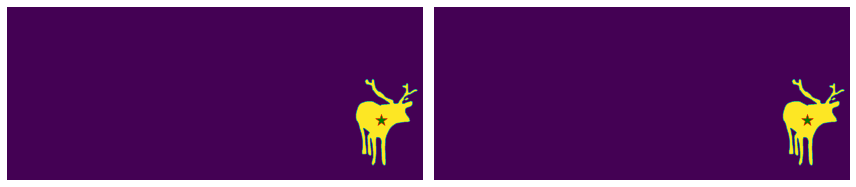

In [79]:
data_idx, sample_idx, instance_idx = 10, 0, 2

masks = get_gt_masks(all_dataset[data_idx][sample_idx])

center_point = get_mask_center(masks[instance_idx], use_area=True)

print("center_point(boundary):", center_point)
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(masks[instance_idx])
ax[0].scatter(
    [center_point[0]],
    [center_point[1]],
    color="green",
    marker="*",
    s=150,
    edgecolor="red",
    linewidth=0.5,
)
ax[0].axis("off")

center_point = get_mask_center(masks[instance_idx])
print("center_point(mask):", center_point)
ax[1].imshow(masks[instance_idx])
ax[1].scatter(
    [center_point[0]],
    [center_point[1]],
    color="green",
    marker="*",
    s=150,
    edgecolor="red",
    linewidth=0.5,
)
ax[1].axis("off")

plt.tight_layout()
plt.show()

### 2. 数据集分辨率统计

In [36]:
def load_dataset(**args):
    fields_list = ["Image", "ImageShape"]

    split = args["split"]
    yaml_path = os.path.join(args["dsdl_dir"], f"set-{split}/{split}.yaml")

    loc_config = dict(
        type="PetrelFileReader",
        working_dir=args["working_dir"],
        conf_path=args["petrel_cfg"],
    )

    ds = DSDLDataset(
        dsdl_yaml=yaml_path, location_config=loc_config, required_fields=fields_list
    )
    
    ds.data_list = ds.data_list[0:100]
    return ds

In [37]:
%%time

with open("data_cfgs.json", "r") as f:
    cfgs = json.load(f)["cfgs"]

all_dataset = []
for item in cfgs:
    all_dataset.append(load_dataset(**item))

Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/BBBC038v1/set-stage1_train/stage1_train.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/DOORS/set-DS1_T/DS1_T.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/TimberSeg/set-original/original.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/NDD20/set-ABOVE/ABOVE.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/LVIS/set-val/val.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/STREETS/set-train/train.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (source): datasets/ZeroWaste-f/set-train/train.yaml
Output file (output): None
Convert Yaml File to Python Code Successfully!
Yaml file (s

In [ ]:
%%time

for ds in all_dataset:
    print("dataset name:", ds._dsdl_yaml.split("/")[1])
    H, W = [], []
    for data in ds:
        if "ImageShape" in data.keys():
            H.append(data.ImageShape[0].width)
            W.append(data.ImageShape[0].height)
        else:
            H.append(data.Image[0].to_array().shape[0])
            W.append(data.Image[0].to_array().shape[1])
    H = np.array(H)
    W = np.array(W)
    print(f"image nmus: {H.shape[0]}, mean size: ({H.mean()}, {W.mean()})")

dataset name: BBBC038v1
image nmus: 100, mean size: (343.15, 388.06)
dataset name: DOORS
image nmus: 100, mean size: (128.0, 128.0)
dataset name: TimberSeg
